## FSRCNN with PyTorch

In [2]:
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
from utils.lab6.imresize import imresize
import numpy as np
import skimage
import os
import glob
from skimage.io import imread
import skimage

os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Data loader

In [3]:
print('STEP 1: DEFINE DATASET')

class T91_images(Dataset):
    def __init__(self, data_dir = "./dataset/lab6/HR_patches_from_T91.npy", HR_patch_size = 64, scale_factor = 4):
        super(T91_images, self).__init__()
        self.HR_patches_np = np.load(data_dir) # pre-processed patches
        self.HR_patch_size = HR_patch_size
        self.scale_factor = scale_factor
        
    def __getitem__(self, idx):
        HR_patch_np = self.HR_patches_np[idx] # high resolution patch
        LR_patch_np = imresize(HR_patch_np, scalar_scale = 1.0 / self.scale_factor) # low resolution patch
        BC_patch_np = imresize(LR_patch_np, scalar_scale = self.scale_factor) # bicubic upsampled patch
        
        HR_patch = torch.from_numpy(HR_patch_np).type(torch.FloatTensor)
        LR_patch = torch.from_numpy(LR_patch_np).type(torch.FloatTensor)
        BC_patch = torch.from_numpy(BC_patch_np).type(torch.FloatTensor)
        
        HR_patch = HR_patch.unsqueeze(0) # size : 1(c) x 64(h) x 64(w)
        LR_patch = LR_patch.unsqueeze(0) # size : 1(c) x 16(h) x 16(w)
        BC_patch = BC_patch.unsqueeze(0) # size : 1(c) x 64(h) x 64(w)
                                
        return HR_patch, LR_patch, BC_patch # Y-channel patches
    
    def __len__(self):
        return len(self.HR_patches_np)
    
class Set5(Dataset):
    def __init__(self, data_dir = './new_dataset/lab6/Set5/', scale_factor=4):
        super(Set5, self).__init__()
        self.image_filenames = [os.path.join(data_dir, x) for x in sorted(os.listdir(data_dir))]
        self.scale_factor = scale_factor

    def load_img(self, filepath):
        img = skimage.io.imread(filepath)
        ch = img.ndim
        if ch == 2:
            img = skimage.color.gray2rgb(img)
        img = skimage.color.rgb2ycbcr(img)

        return img / 255.
    
    def calculate_valid_crop_size(self, crop_size, scale_factor):
        return crop_size - (crop_size % scale_factor)
    
    def __getitem__(self, idx):
        # load image
        img_np = self.load_img(self.image_filenames[idx])
        
        # original HR image size
        h, w, _ = img_np.shape
                
        # determine valid HR image size with scale factor
        HR_img_w = self.calculate_valid_crop_size(w, self.scale_factor)
        HR_img_h = self.calculate_valid_crop_size(h, self.scale_factor)

        # determine lr_img LR image size
        LR_img_w = HR_img_w // self.scale_factor
        LR_img_h = HR_img_h // self.scale_factor

        HR_img_np = img_np[:HR_img_h,:HR_img_w,:] # high resolution image
        LR_img_np = imresize(HR_img_np, scalar_scale = 1.0/self.scale_factor) # low resolution image
        BC_img_np = imresize(LR_img_np, scalar_scale = self.scale_factor) # bicubic upsampled image
        
        HR_img = torch.from_numpy(HR_img_np).type(torch.FloatTensor).permute(2,0,1) # size : 3(c) x h x w
        LR_img = torch.from_numpy(LR_img_np).type(torch.FloatTensor).permute(2,0,1) # size : 3(c) x (h/scale_factor) x (w/scale_factor)
        BC_img = torch.from_numpy(BC_img_np).type(torch.FloatTensor).permute(2,0,1) # size : 3(c) x h x w
        
        return HR_img, LR_img, BC_img # YCbCr images

    def __len__(self):
        return len(self.image_filenames)

STEP 1: DEFINE DATASET


In [4]:
print('STEP 2: LOADING DATASET')

scale_factor = 4 # 1/4 down scaling

train_dataset = T91_images(data_dir = "./dataset/lab6/HR_patches_from_T91.npy", HR_patch_size = 64, scale_factor = scale_factor)
test_dataset = Set5(data_dir = "./new_dataset/lab6/Set5/", scale_factor = scale_factor)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, 
                                           batch_size = 64, 
                                           shuffle = True, num_workers = 4)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, 
                                          batch_size = 1, 
                                          shuffle = False)

STEP 2: LOADING DATASET


### Visualize a training sample

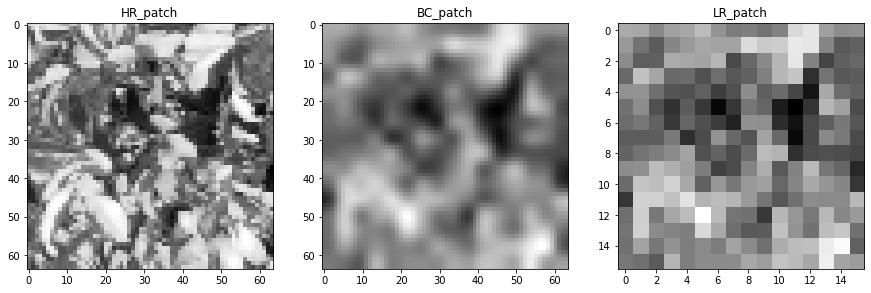

In [41]:
(HR_patch, LR_patch, BC_patch) = train_dataset[400]
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
ax1.imshow(HR_patch.squeeze(0).numpy(), cmap='gray')
ax1.set_title("HR_patch")
ax2.imshow(BC_patch.squeeze(0).numpy(), cmap='gray')
ax2.set_title("BC_patch")
ax3.imshow(LR_patch.squeeze(0).numpy(), cmap='gray')
ax3.set_title("LR_patch")
plt.show()

### FSRCNN Architecture

In [6]:
print('STEP 3: CREATE MODEL CLASS (FSRCNN)')

class FSRCNN(nn.Module):
    def __init__(self, scale_factor = 4):
        super(FSRCNN, self).__init__()
        #############
        # CODE HERE #
        #############        
        # Feature extraction
        self.feature_extraction = nn.Sequential(
                                nn.Conv2d(in_channels=1, out_channels=56, kernel_size=5, stride=1, padding=2),
                                nn.PReLU()
                                )
        
        # shrinking
        self.shrinking = nn.Sequential(
                                nn.Conv2d(in_channels=56, out_channels=12, kernel_size=1, stride=1, padding=0),
                                nn.PReLU()
                                )
        
        # non-linear mapping
        self.non_lin_mapping = nn.Sequential(
                                nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1),
                                nn.PReLU(),
                                nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1),
                                nn.PReLU(),
                                nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1),
                                nn.PReLU(),
                                nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1),
                                nn.PReLU()
                                )
        
        # expanding
        self.expanding = nn.Sequential(
                                nn.Conv2d(in_channels=12, out_channels=56, kernel_size=1, stride=1, padding=0),
                                nn.PReLU()
                                )
        
        # deconv
        self.deconvolution = nn.ConvTranspose2d(in_channels=56, out_channels=1, 
                                                kernel_size=9, stride=4, padding=4, output_padding=3)
            
    def weight_init(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight.data, mean = 0.0, std = 0.02)
#                 nn.init.kaiming_normal_(m.weight.data, a=0.25) # for SGD
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight.data, mean = 0.0, std = 0.001)
                if m.bias is not None:
                    m.bias.data.zero_()
    
    
    def forward(self, LR_patch):
        x = self.feature_extraction(LR_patch)
        x = self.shrinking(x)
        x = self.non_lin_mapping(x)
        x = self.expanding(x)
        x = self.deconvolution(x)
        
        output = x
        
        return output

STEP 3: CREATE MODEL CLASS (FSRCNN)


In [7]:
print('STEP 4: INSTANTIATE MODEL CLASS')


model = FSRCNN(scale_factor = scale_factor)
model.weight_init()
num_total_params = sum(p.numel() for p in model.parameters())
print("The number of parameters : ", num_total_params)

#######################
#  USE GPU FOR MODEL  #
#######################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

STEP 4: INSTANTIATE MODEL CLASS
The number of parameters :  12644


FSRCNN(
  (feature_extraction): Sequential(
    (0): Conv2d(1, 56, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): PReLU(num_parameters=1)
  )
  (shrinking): Sequential(
    (0): Conv2d(56, 12, kernel_size=(1, 1), stride=(1, 1))
    (1): PReLU(num_parameters=1)
  )
  (non_lin_mapping): Sequential(
    (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): PReLU(num_parameters=1)
    (4): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): PReLU(num_parameters=1)
    (6): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): PReLU(num_parameters=1)
  )
  (expanding): Sequential(
    (0): Conv2d(12, 56, kernel_size=(1, 1), stride=(1, 1))
    (1): PReLU(num_parameters=1)
  )
  (deconvolution): ConvTranspose2d(56, 1, kernel_size=(9, 9), stride=(4, 4), padding=(4, 4), output_padding=(3, 3))
)

In [8]:
print('STEP 5: INSTANTIATE OPTIMIZER CLASS')

lr_conv = 1e-3
lr_deconv = 1e-4
# momentum = 0.9

param_conv = list(model.feature_extraction.parameters())+\
             list(model.shrinking.parameters())+\
             list(model.non_lin_mapping.parameters())+\
             list(model.expanding.parameters())

param_deconv = model.deconvolution.parameters()

# optimizer = torch.optim.SGD([{'params':param_conv},
#                              {'params':param_deconv, 'lr':lr_deconv}],
#                              lr = lr_conv, momentum = momentum)

optimizer = torch.optim.Adam([{'params':param_conv},
                             {'params':param_deconv, 'lr':lr_deconv}],
                             lr = lr_conv)

STEP 5: INSTANTIATE OPTIMIZER CLASS


### Train the FSRCNN model and print PSNR for every epochs

In [9]:
import time
print('STEP 6: INSTANTIATE LOSS CLASS')

# Use CrossEntropyLoss
criterion = nn.MSELoss()

print('STEP 7: TRAIN THE MODEL')

if not os.path.exists("./weights/"):
    os.mkdir("./weights/")

if not os.path.exists("./weights/lab6/"):
    os.mkdir("./weights/lab6/")

num_epochs = 51

def PSNR(pred, gt, s = 0): # input images : 0~1 normalized / s : scale factor
    if pred.is_cuda:
        pred = pred.cpu()
    if gt.is_cuda:
        gt = gt.cpu()
    pred = pred[:,:,s:-s,s:-s] # shave border
    gt = gt[:,:,s:-s,s:-s]
    pred = pred.clamp(0, 1)
    diff = pred - gt
    mse = np.mean(diff.numpy() ** 2)
    if mse == 0:
        return 100
    return 10 * np.log10(1.0 / mse)

for epoch in range(num_epochs):
    # training stage
    model.train()
    total_loss = 0
    start = time.time()
    for i, (HR_patch, LR_patch, BC_patch) in enumerate(train_loader):
        
        HR_patch, LR_patch, BC_patch = HR_patch.to(device), LR_patch.to(device), BC_patch.to(device)
        optimizer.zero_grad()
        outputs = model(LR_patch)
        loss = criterion(outputs, HR_patch)
        total_loss += loss.item()
        # print(train_loss / (batch_num + 1))
        loss.backward()
        optimizer.step()
        
        
    # test stage
    end = time.time()
    model.eval()
    total_psnr = 0
    total_psnr_bic = 0
    # Iterate through test dataset
    with torch.no_grad():
        for (HR_img, LR_img, BC_img) in test_loader:
            HR_img, LR_img, BC_img = HR_img.to(device), LR_img.to(device), BC_img.to(device)
            outputs = model(LR_img[:,0,:,:].unsqueeze(1))
            # psnr
            psnr_bic = PSNR(HR_img[:,0,:,:].unsqueeze(1), BC_img[:,0,:,:].unsqueeze(1), 4)
            psnr_fsrcnn = PSNR(outputs, HR_img[:,0,:,:].unsqueeze(1), 4)
            total_psnr += psnr_fsrcnn
            total_psnr_bic += psnr_bic
    print("Epoch: {}. Loss: {:.6f}. PSNR: {:.3f} (bicubic)        {:.3f} (FSRCNN) Elapsed time: {} sec".format(epoch, total_loss/len(train_loader.dataset), total_psnr_bic/len(test_loader.dataset), total_psnr/len(test_loader.dataset), end-start))    
        
            
    
    # save weights
    if epoch % 5 == 0 and epoch != 0:
        torch.save({'state_dict':model.state_dict()},'./weights/lab6/checkpoint_%03d.pkl'%(epoch))

STEP 6: INSTANTIATE LOSS CLASS
STEP 7: TRAIN THE MODEL
Epoch: 0. Loss: 0.000340. PSNR: 28.432 (bicubic)        25.293 (FSRCNN) Elapsed time: 29.629066467285156 sec
Epoch: 1. Loss: 0.000046. PSNR: 28.432 (bicubic)        26.324 (FSRCNN) Elapsed time: 29.251519203186035 sec
Epoch: 2. Loss: 0.000038. PSNR: 28.432 (bicubic)        27.667 (FSRCNN) Elapsed time: 29.34244132041931 sec
Epoch: 3. Loss: 0.000029. PSNR: 28.432 (bicubic)        26.978 (FSRCNN) Elapsed time: 29.049187183380127 sec
Epoch: 4. Loss: 0.000026. PSNR: 28.432 (bicubic)        28.701 (FSRCNN) Elapsed time: 29.188860416412354 sec
Epoch: 5. Loss: 0.000025. PSNR: 28.432 (bicubic)        28.640 (FSRCNN) Elapsed time: 28.905831813812256 sec
Epoch: 6. Loss: 0.000024. PSNR: 28.432 (bicubic)        28.983 (FSRCNN) Elapsed time: 28.998809814453125 sec
Epoch: 7. Loss: 0.000024. PSNR: 28.432 (bicubic)        29.029 (FSRCNN) Elapsed time: 27.53324842453003 sec
Epoch: 8. Loss: 0.000023. PSNR: 28.432 (bicubic)        29.128 (FSRCNN) Ela

### Visualize and compare test examples (RGB color)

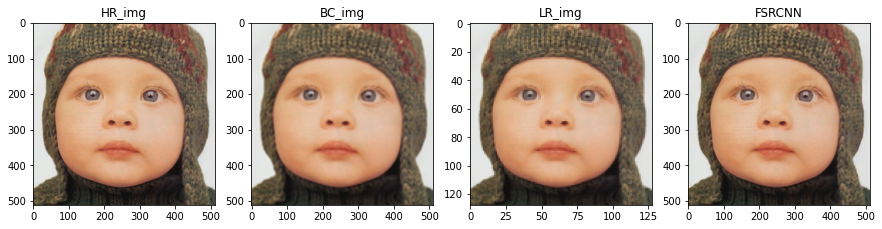

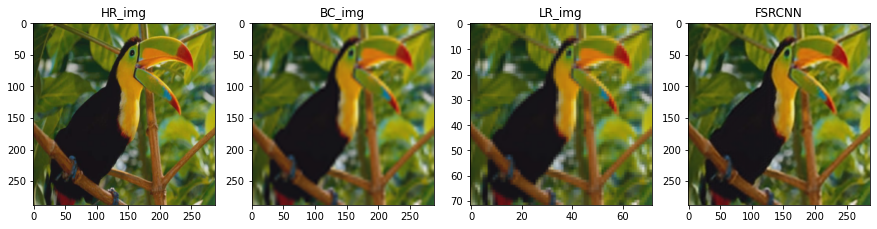

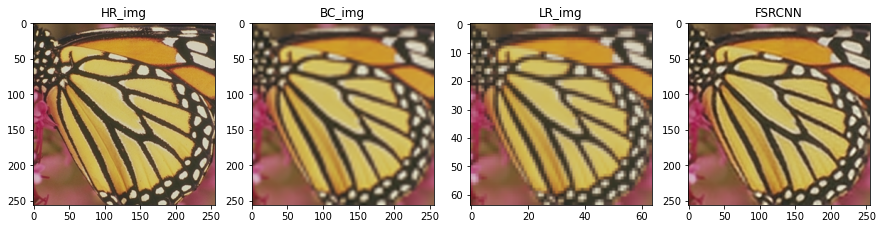

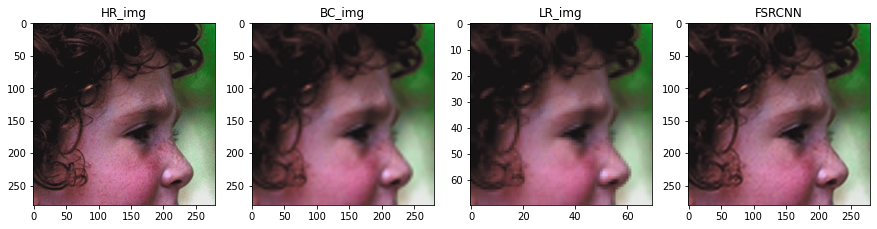

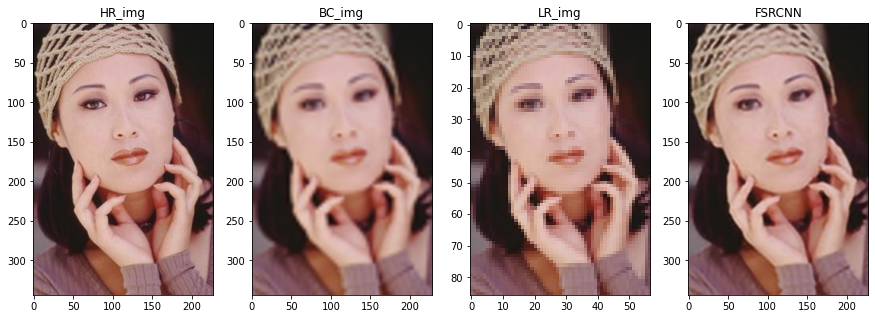

In [231]:
def ycbcr2rgb(im): # input image : ranges from 0 to 255
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = im.astype(np.float)
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)

trained_weight = torch.load("./weights/lab6/checkpoint_050.pkl")
model.load_state_dict(trained_weight['state_dict'])
model.eval()

with torch.no_grad():
    for (HR_img, LR_img, BC_img) in test_loader:
        
        HR_img, LR_img, BC_img = HR_img.to(device), LR_img.to(device), BC_img.to(device)
        
        outputs = model(LR_img[:,0,:,:].unsqueeze(1))
        outputs = outputs.detach().cpu()
        outputs = torch.cat((outputs[:,0,:,:], BC_img[:,1,:,:].cpu(), BC_img[:,2,:,:].cpu()))
        out = (ycbcr2rgb((outputs.numpy()*255).T))
        out = np.rot90(out,3)
        out = np.fliplr(out)
        fig = plt.figure(figsize=(15,5))
        ax4 = fig.add_subplot(1, 4, 4)
        ax4.imshow(out)
        ax4.set_title("FSRCNN")
        
        LR_img = LR_img[0].cpu()
        LR_img = (ycbcr2rgb((LR_img.numpy()*255).T))
        lr = np.rot90(LR_img,3)
        lr = np.fliplr(lr)
        ax3 = fig.add_subplot(1, 4, 3)
        ax3.imshow(lr)
        ax3.set_title("LR_img")
        
        HR_img = HR_img[0].cpu()
        HR_img = (ycbcr2rgb((HR_img.numpy()*255).T))
        hr = np.rot90(HR_img,3)
        hr = np.fliplr(hr)
        ax1 = fig.add_subplot(1, 4, 1)
        ax1.imshow(hr)
        ax1.set_title("HR_img")
        
        BC_img = BC_img[0].cpu()
        BC_img = (ycbcr2rgb((BC_img.numpy()*255).T))
        bc = np.rot90(BC_img,3)
        bc = np.fliplr(bc)
        ax2 = fig.add_subplot(1, 4, 2)
        ax2.imshow(bc)
        ax2.set_title("BC_img")
        plt.show()
        

### *References*
[1] https://cv-tricks.com/deep-learning-2/image-super-resolution-to-enhance-photos/ <br>
[2] https://deepsense.ai/using-deep-learning-for-single-image-super-resolution/ <br>
[3] Dong et al., "Learning a deep convolutional network for image super-resolution", *ECCV*, 2014. <br>
[4] Dong et al., "Accelerating the super-resolution convolutional neural network", *ECCV*, 2016. <br>
[5] https://medium.com/apache-mxnet/transposed-convolutions-explained-with-ms-excel-52d13030c7e8 <br>
[6] https://pytorch.org/docs/master/nn.html#torch.nn.ConvTranspose2d